2024-02-29 11:02:50,118 - INFO - Configuration loaded successfully.
2024-02-29 11:02:50,132 - INFO - Data loaded successfully from ..//data//raw//diabetes.csv


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



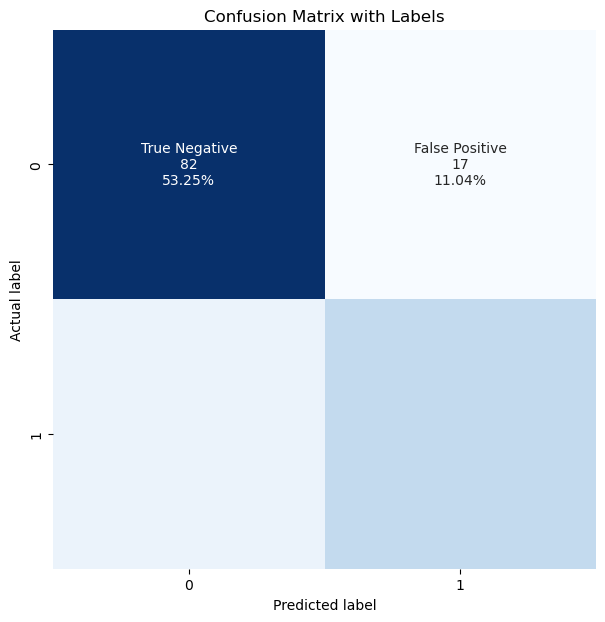

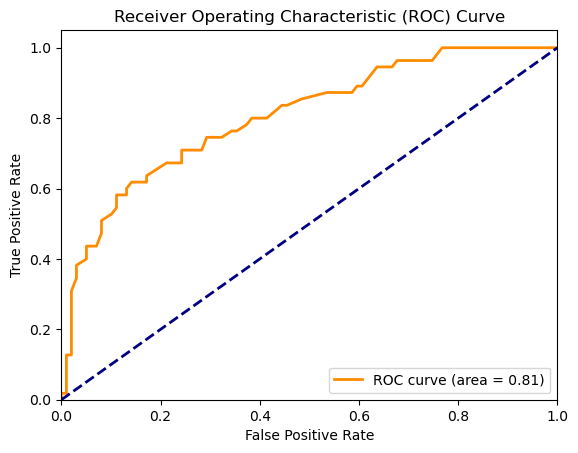

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import sys 
sys.path.append('../Helpers')
from data_helpers import load_config, load_data



# Data loading and preprocessing
def load_and_preprocess_data(config_path):
    # Load configuration settings from a JSON file
    config = load_config(config_path)

    if not config:
        raise Exception("Failed to load configuration.")

    # Load the dataset
    data_path = config['data_path']
    df = load_data(data_path)

    if df is None:
        raise Exception("Failed to load the data.")

    # Handling missing values
    for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
        df[col].replace(0, np.nan, inplace=True)
        
    df['BMI_Age_Interaction'] = df['BMI'] * df['Age']
    
    return df

# Splitting dataset
def split_dataset(df):
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Building the model pipeline
def build_model_pipeline():
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    classifier = RandomForestClassifier(random_state=42)

    pipeline = Pipeline(steps=[('imputer', imputer),
                               ('scaler', scaler),
                               ('poly', poly),
                               ('classifier', classifier)])
    return pipeline

# Model training
def train_model(pipeline, X_train, y_train):
    pipeline.fit(X_train, y_train)

# Updated model evaluation with ROC Curve plotting
def evaluate_model(pipeline, X_test, y_test):
    predictions = pipeline.predict(X_test)
    probabilities = pipeline.predict_proba(X_test)[:, 1]  # For ROC AUC score

    print("Classification Report:\n", classification_report(y_test, predictions))
    plot_confusion_matrix(y_test, predictions)
    plot_roc_curve(y_test, probabilities)

# Helper function to format confusion matrix labels
def format_confusion_matrix_labels(cm):
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    return np.asarray(labels).reshape(2,2)

# Plotting confusion matrix
def plot_confusion_matrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    labels = format_confusion_matrix_labels(cm)
    
    # Making the figsize larger to fit the labels
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=labels, fmt='s', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix with Labels')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    
# Function to plot the ROC curve
def plot_roc_curve(y_test, probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    


if __name__ == "__main__":
    df = load_and_preprocess_data('../config/config.json')
    X_train, X_test, y_train, y_test = split_dataset(df)
    pipeline = build_model_pipeline()
    train_model(pipeline, X_train, y_train)
    evaluate_model(pipeline, X_test, y_test)
